# Can we force a 0.5 ROC by randomizing the data?

Randomize the labels attached to the training pairs. Pairs are kept the same. Retries without convolved features to see if convolving removes the ability to overfit.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression

from glob import glob
import seaborn as sns
from collections import defaultdict

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [4]:
%matplotlib inline

In [5]:
np.random.seed(1348512374)

np.random.seed(20171101)

## Read deepwalk embeddings

In [6]:
sizes = list(2**i for i in range(3, 9))

In [7]:
sizes

[8, 16, 32, 64, 128, 256]

In [8]:
features = {}
for vecsize in sizes:
    fname = "../embeddings/normal_{}.txt".format(vecsize)

    features[vecsize] = pd.read_csv(
        fname, sep=" ", skiprows=1,
        names=["uid"] + ["f{}".format(i) for i in range(vecsize)]
    )

## Read training data

In [9]:
traind = pd.read_csv("../data/clean_train.tsv", sep='\t')

In [10]:
traind.shape

(138639, 5)

In [11]:
traind.head(3)

,chemical_id,disease_id,category,chemical_uid,disease_uid
0,DB00035,ORPHA:100054,0,22434,989
1,DB00104,ORPHA:100054,0,3845,989
2,DB00115,ORPHA:100054,0,54459,989


In [12]:
traind["category"].value_counts()

0    137008
1      1631
Name: category, dtype: int64

## Randomize training data labels

But keep the proportions constant.

In [13]:
mapping = (pd
    .read_csv("../data/node_map.tsv", sep='\t')
    [["uid", ":ID"]]
    .rename(columns={":ID": "node_id"})
)

In [14]:
labels = list(traind["category"])
np.random.shuffle(labels)

chems = list(traind["chemical_id"])
np.random.shuffle(chems)

dises = list(traind["disease_id"])
np.random.shuffle(dises)

rand_train = pd.DataFrame(
    list(zip(chems, dises, labels)),
    columns=["chemical_id", "disease_id", "category"]
)

In [15]:
rand_train = (rand_train
    .merge(
        mapping, how="inner", left_on="chemical_id", right_on="node_id"
    )
    .drop("node_id", axis=1)
    .rename(columns={"uid": "chemical_uid"})
    .merge(
        mapping, how="inner", left_on="disease_id", right_on="node_id"
    )
    .drop("node_id", axis=1)
    .rename(columns={"uid": "disease_uid"})
)

In [16]:
rand_train.shape

(138639, 5)

In [17]:
rand_train.drop_duplicates().shape

(92098, 5)

### Check for amount overlap

In [18]:
(rand_train
    .query("category == 1")
    .merge(
        traind.query("category == 1"),
        how="inner", on=["chemical_id", "disease_id"]
    )
).shape

(12, 8)

## Subsample random training data

In [19]:
trainpos = rand_train.query("category == 1")
K = 3

train = (trainpos
    .append(
        (rand_train
            .query("category == 0")
            .sample(len(trainpos) * K)
        )
    )
    .reset_index(drop=True)
)

In [20]:
train.head()

,chemical_id,disease_id,category,chemical_uid,disease_uid
0,DB01147,ORPHA:94064,1,2054,5583
1,DB00618,ORPHA:94064,1,39279,5583
2,DB01003,ORPHA:94064,1,48725,5583
3,DB00949,ORPHA:1226,1,54805,8147
4,DB00582,ORPHA:1226,1,44712,8147


In [21]:
train["category"].value_counts(normalize=True)

0    0.75
1    0.25
Name: category, dtype: float64

---

## Add in features

In [22]:
def add_features(df, features):
    return (df
        .merge(
            features, how="inner", left_on="chemical_uid", right_on="uid"
        )
        .drop("uid", axis=1)
        .merge(
            features, how="inner", left_on="disease_uid", right_on="uid"
        )
        .drop("uid", axis=1)
    )

In [23]:
tmp = {}
for vecsize, featdf in features.items():
    tmp[vecsize] = add_features(train, featdf)

## Train classifiers

In [24]:
models = {}
for vecsize, tdata in tmp.items():
    feat_cols = (
        ["f{}_x".format(i) for i in range(vecsize)]
        + ["f{}_y".format(i) for i in range(vecsize)]
    )
    
    models[vecsize] = LogisticRegression(C=1e9)
    models[vecsize].fit(tdata[feat_cols], tdata["category"])

## Predict on holdout data

In [25]:
holdoutd = pd.read_csv("../data/clean_holdout.tsv", sep='\t')

In [26]:
holdoutd.head()

,chemical_id,disease_id,category,chemical_uid,disease_uid
0,DB00035,ORPHA:100050,0,22434,14962
1,DB00104,ORPHA:100050,0,3845,14962
2,DB00121,ORPHA:100050,0,41945,14962
3,DB00131,ORPHA:100050,0,7630,14962
4,DB00139,ORPHA:100050,0,31269,14962


In [27]:
results = {}
for vecsize, regmodel in models.items():
    test = add_features(holdoutd.drop("category", axis=1), features[vecsize])
    
    featcols = (
        ["f{}_x".format(i) for i in range(vecsize)]
        + ["f{}_y".format(i) for i in range(vecsize)]
    )

    ans = test.assign(predval = lambda df: regmodel.predict_proba(df[featcols])[:, 1])
    
    results[vecsize] = (ans
        [["chemical_id", "disease_id", "predval"]]
        .merge(
            holdoutd[["chemical_id", "disease_id", "category"]],
            how="inner", on=["chemical_id", "disease_id"]
        )
    )

In [28]:
fusion = holdoutd[["chemical_id", "disease_id", "category"]]

for vecsize, res in results.items():
    fusion = (fusion
        .merge(
            res[["chemical_id", "disease_id", "predval"]],
            how="inner", on=["chemical_id", "disease_id"]
        )
        .rename(columns={"predval": "predval{}".format(vecsize)})
    )

In [29]:
fusion.shape

(39288, 9)

In [30]:
fusion.head()

,chemical_id,disease_id,category,predval8,predval16,predval32,predval64,predval128,predval256
0,DB00035,ORPHA:100050,0,0.270747,0.293891,0.162406,0.468301,0.342480,0.002663
1,DB00104,ORPHA:100050,0,0.290909,0.266444,0.191535,0.537071,0.365286,0.002059
2,DB00121,ORPHA:100050,0,0.278705,0.308340,0.162336,0.470469,0.440458,0.001307
3,DB00131,ORPHA:100050,0,0.278486,0.310784,0.179420,0.539288,0.396089,0.003410
4,DB00139,ORPHA:100050,0,0.288490,0.336214,0.158135,0.485823,0.338568,0.002013


---

## Draw ROC curves

In [31]:
def plot_roc(res_df, metrics, name_map, title="ROC"):
    auroc_results = defaultdict(dict)

    for metric in metrics:
        tmp = res_df[["category", metric]].sort_values(metric)
        fpr, tpr, thresh = roc_curve(tmp["category"], tmp[metric])

        auroc_results[metric]['fpr'] = fpr
        auroc_results[metric]['tpr'] = tpr
        auroc_results[metric]['thresh'] = thresh
        auroc_results[metric]['auc'] = auc(fpr, tpr)

    lw = 4
    x = [i for i in np.arange(0.0,1.01,.01)]
    plt.plot(x,x, 'k--', lw = 2)
    for metric in metrics:
        plt.plot(auroc_results[metric]['fpr'], auroc_results[metric]['tpr'], lw=lw,
                 label='{0} (area = {1:0.2f})'
                     .format(name_map[metric], auroc_results[metric]['auc']))
    fig = plt.gcf()
    fig.set_size_inches(8, 7)
    fig.set_tight_layout(False)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel('FPR', size=20)
    plt.ylabel('TPR', size=20)
    plt.title(title, size=24)
    plt.legend(loc="lower right", frameon=True, shadow=True, prop={'size':16});

In [32]:
def plot_pr(res_df, metrics, name_map, title="ROC"):
    auroc_results = defaultdict(dict)

    for metric in metrics:
        tmp = res_df[["category", metric]]
        precision, recall, thresh = precision_recall_curve(tmp["category"], tmp[metric])

        auroc_results[metric]['precision'] = precision
        auroc_results[metric]['recall'] = recall
        auroc_results[metric]['thresh'] = thresh
        auroc_results[metric]['auc'] = auc(recall, precision)

    lw = 4
    x = [i for i in np.arange(0.0,1.01,.01)]
    for metric in metrics:
        plt.plot(auroc_results[metric]['recall'], auroc_results[metric]['precision'], lw=lw,
                 label='{0} (area = {1:0.2f})'
                     .format(name_map[metric], auroc_results[metric]['auc']))
    fig = plt.gcf()
    fig.set_size_inches(8, 7)
    fig.set_tight_layout(False)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel('Recall', size=20)
    plt.ylabel('Precision', size=20)
    plt.title(title, size=24)
    plt.legend(loc="upper right", frameon=True, shadow=True, prop={'size':16});

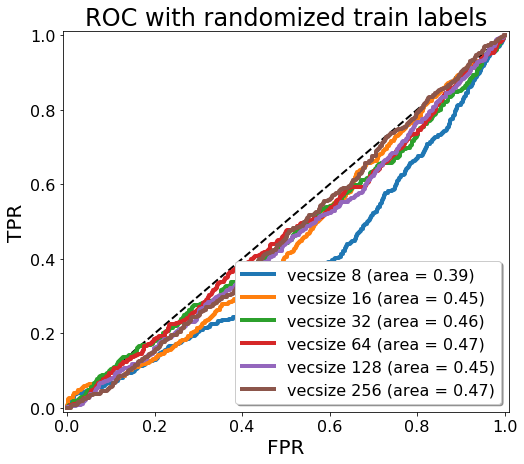

In [33]:
plot_roc(
    fusion,
    ["predval{}".format(i) for i in sizes],
    {
        "predval{}".format(i): "vecsize {}".format(i)
        for i in sizes
    },
    title="ROC with randomized train labels"
)

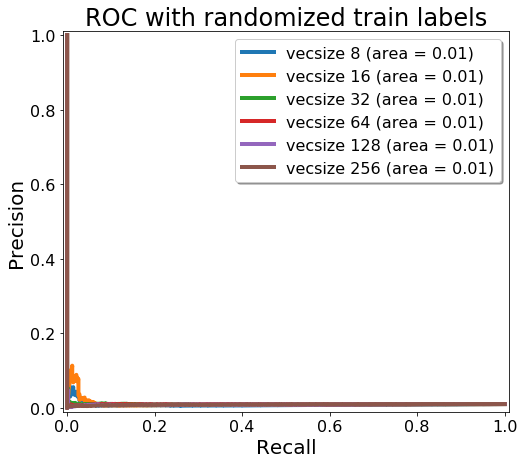

In [34]:
plot_pr(
    fusion,
    ["predval{}".format(i) for i in sizes],
    {
        "predval{}".format(i): "vecsize {}".format(i)
        for i in sizes
    },
    title="ROC with randomized train labels"
)

the pr curve looks correct. do we expect the roc to be all on y=x? let's try again with complete randomization